In [1]:
import argparse
import gc
import json
import math
import os
from collections import defaultdict

import torch as t
import numpy as np
from einops import rearrange
from tqdm import tqdm, trange
from nnsight import LanguageModel

from dictionary_learning import AutoEncoder

from activation_utils import SparseAct
from attribution import patching_effect, jvp
from circuit_plotting import plot_circuit, plot_circuit_posaligned
from loading_utils import load_examples, load_examples_nopair
import histogram_aggregator as ha


%load_ext autoreload
%autoreload 2

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Node and Edge Histograms

In [4]:
# pythia_hist = ha.HistAggregator()
# pythia_hist.load('./circuits/NeelNanda_pile-10k_dict10_node0.1_edge0.01_n9990_aggnone_threshTrue_methodig_prunefirst-layer-sink_modelEleutherAI_pythia-70m-deduped.hist.pt').cpu()
gpt_hist = ha.HistAggregator()
gpt_hist.load('./circuits/NeelNanda_pile-10k_dictgpt2_node2.0-sparsity_edge15.0-sparsity_aggnone_methodig_prunefirst-layer-sink_modelgpt2.hist.pt').cpu()


Successfully loaded histograms at ./circuits/NeelNanda_pile-10k_dictgpt2_node2.0-sparsity_edge15.0-sparsity_aggnone_methodig_prunefirst-layer-sink_modelgpt2.hist.pt


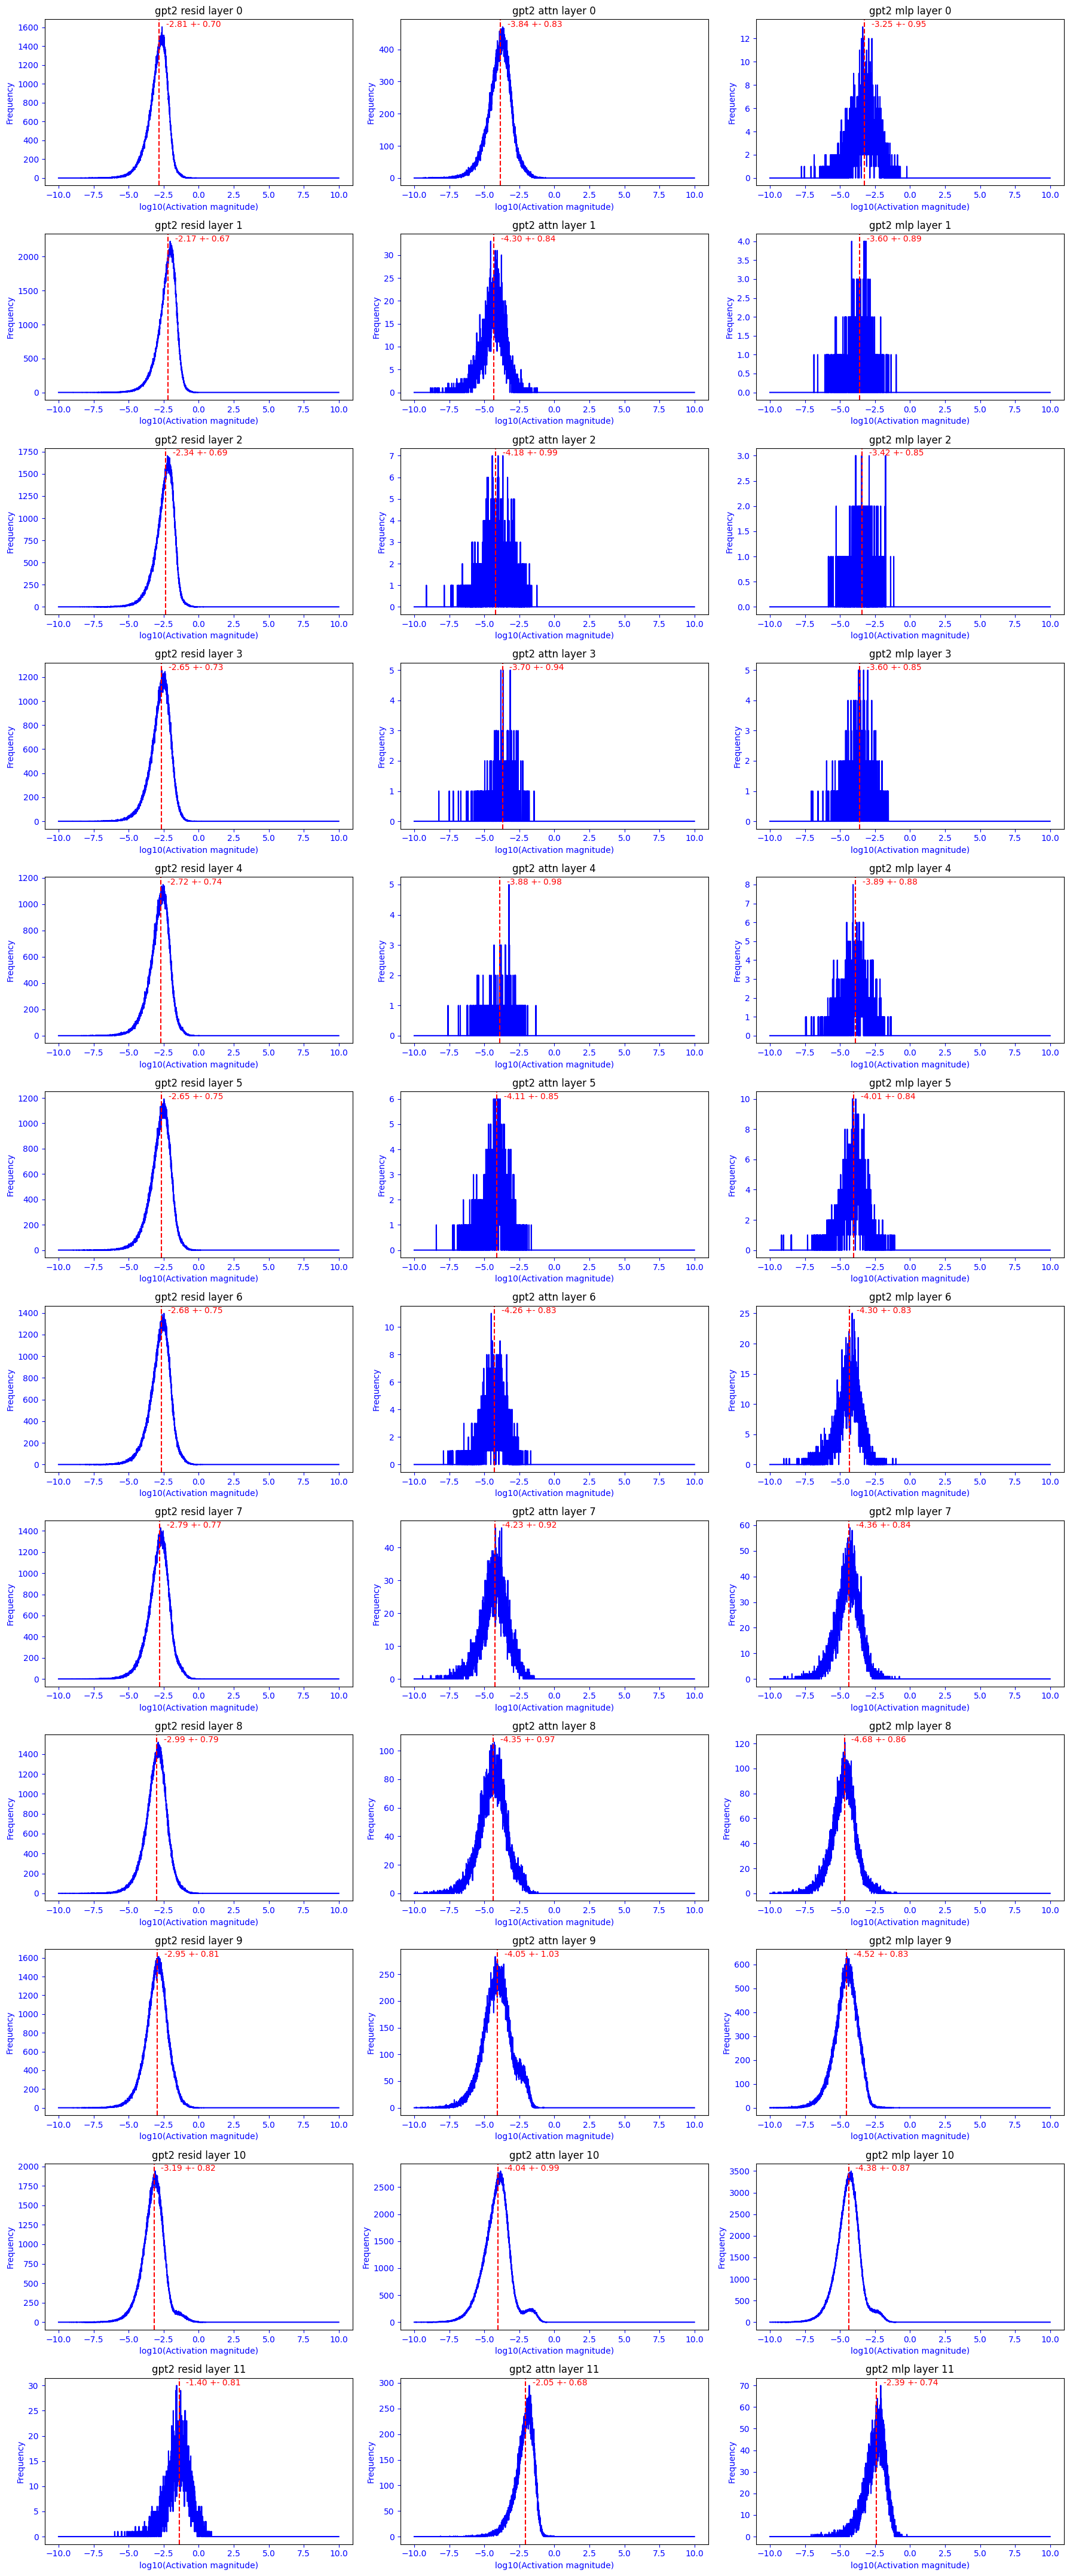

In [5]:
gpt_hist.plot(12, 'nodes', 'acts')

In [9]:
gpt_hist.edge_acts['mlp_0']['resid_0'].sum()

2579.0

/root/feature-circuits/histogram_aggregator.py:200: RuntimeWarning: invalid value encountered in scalar divide
  mean = (bins * hist).sum() / total


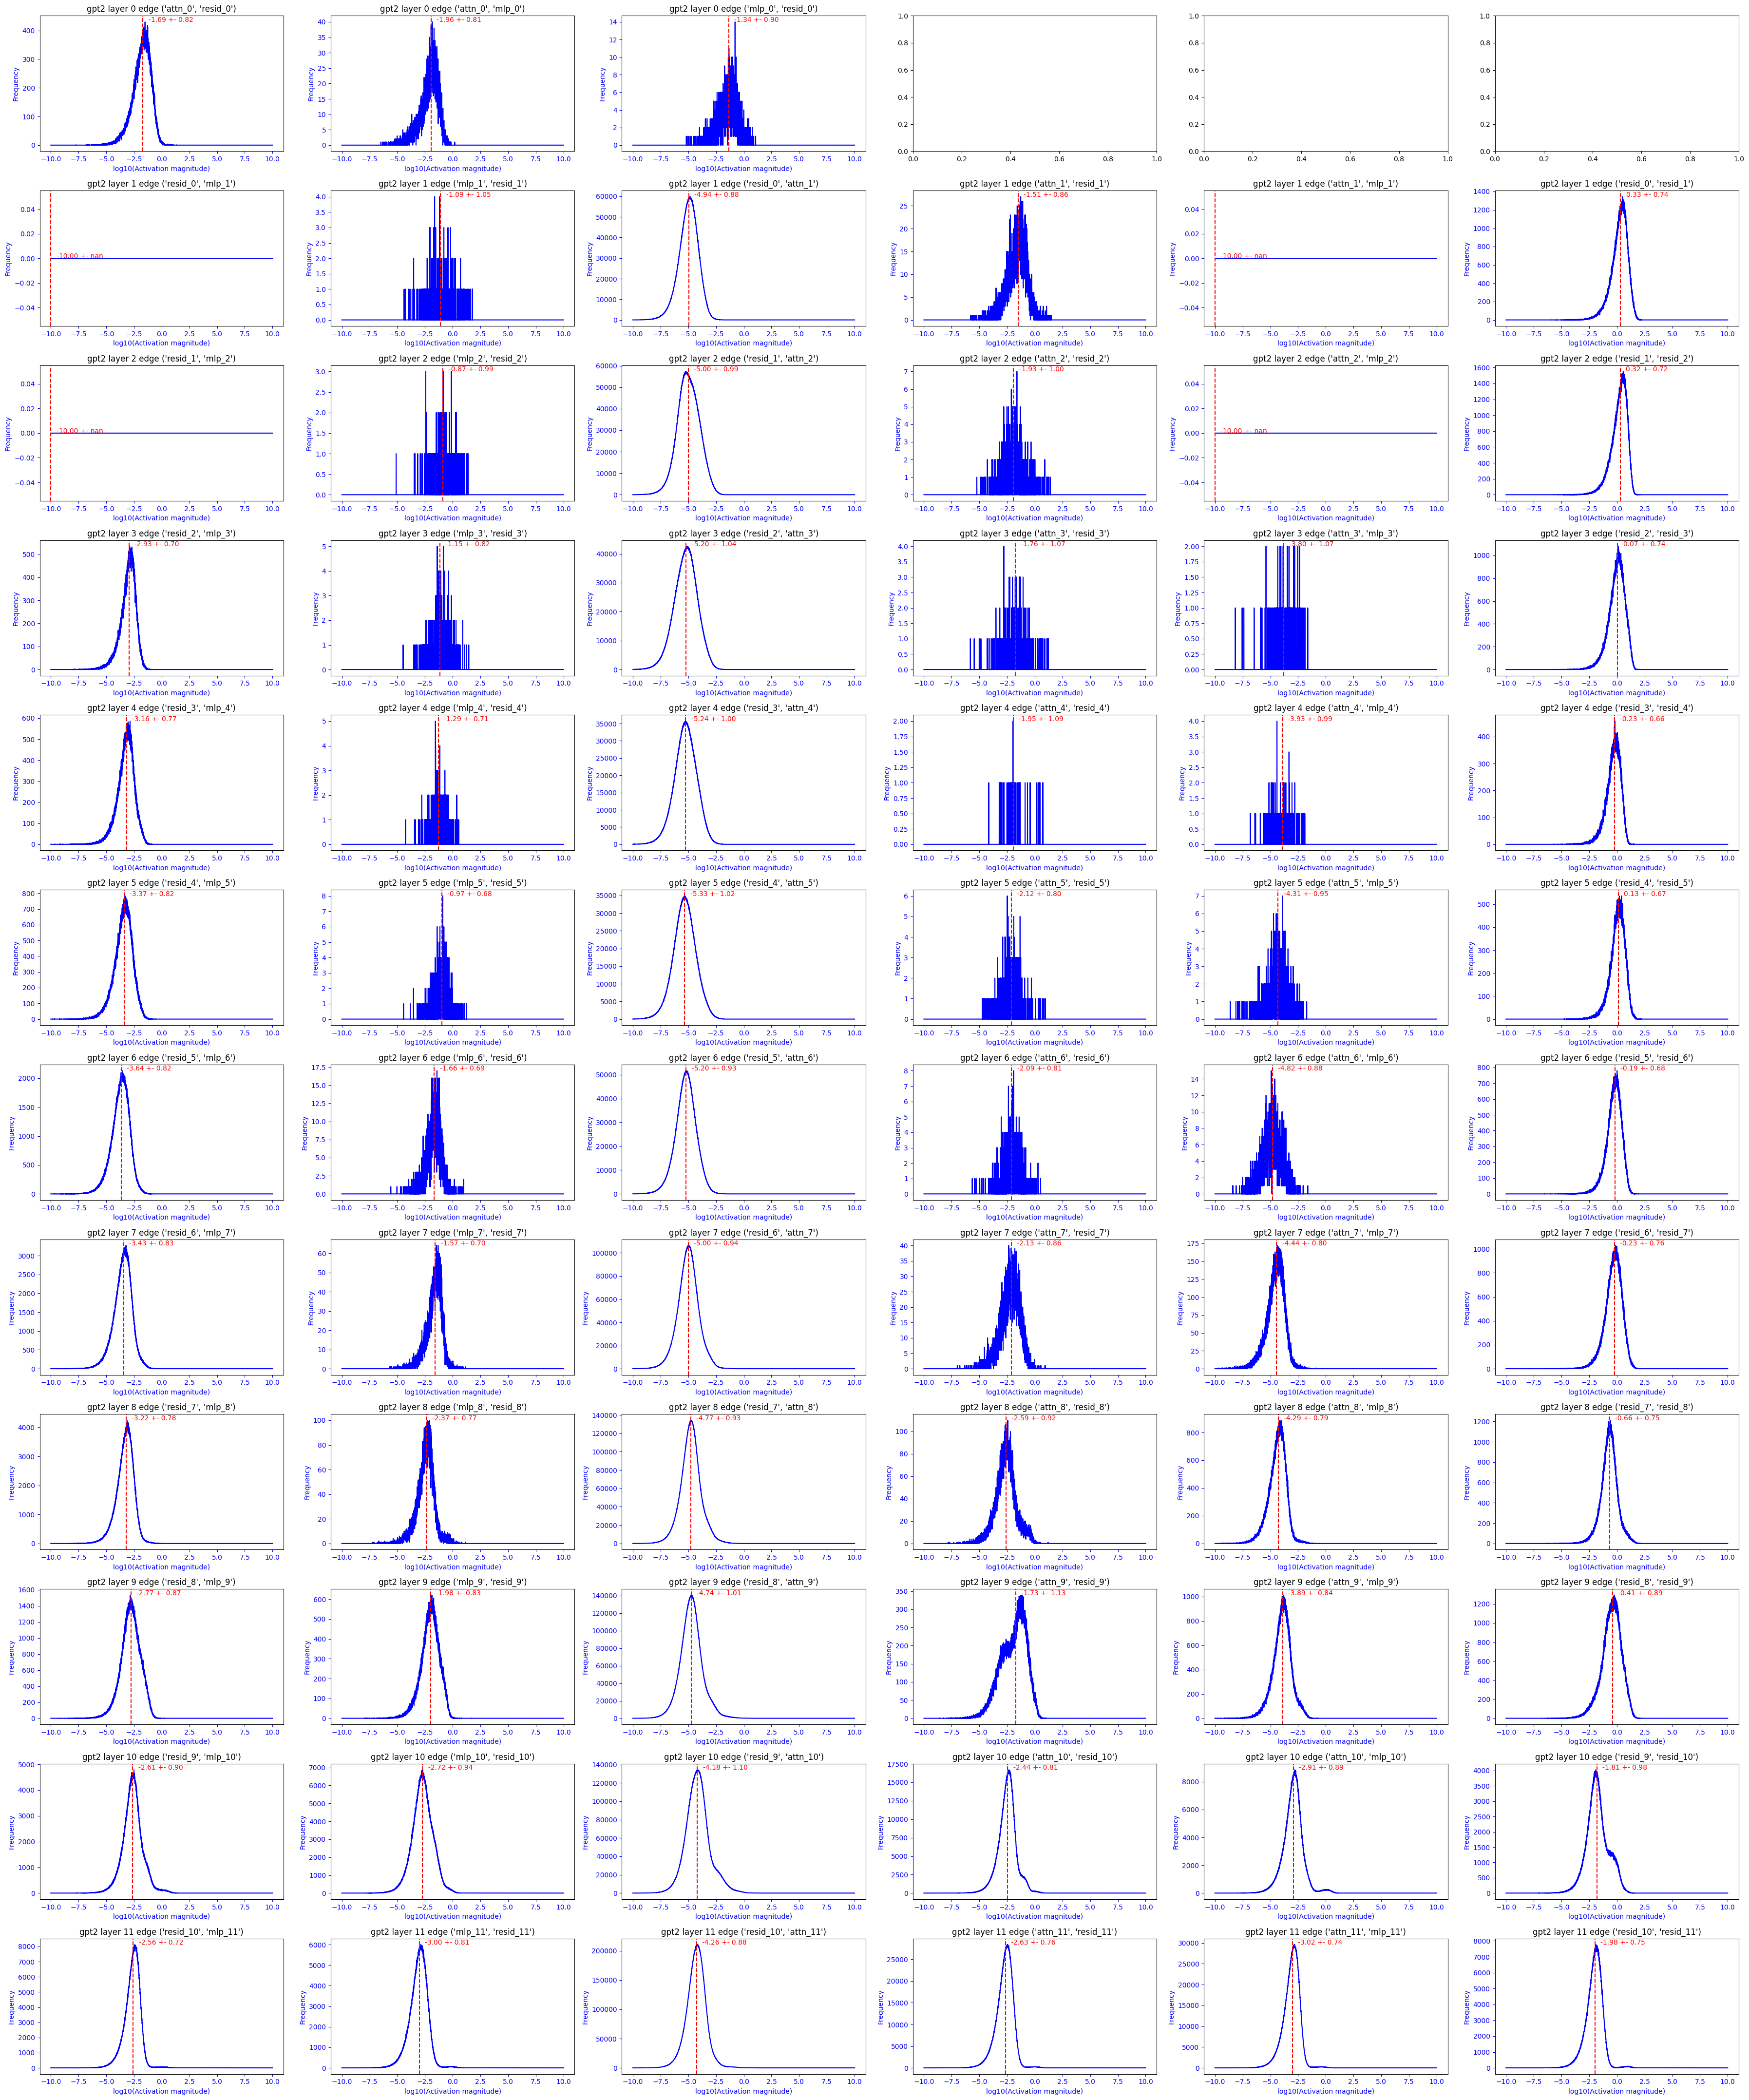

In [6]:
gpt_hist.plot(12, 'edges', 'acts')

In [ ]:
pythia_hist.plot(6, 'nodes', 'acts')

In [ ]:
pythia_hist.plot(6, 'edges', 'acts', thresh=0.1)

In [ ]:
gpt_hist.plot(12, 'edges', 'acts', thresh=30, thresh_type=ha.ThresholdType.PEAK_MATCH)

In [ ]:
gpt_hist.n_samples = {}
for k in gpt_hist.node_acts.keys():
    gpt_hist.n_samples[k] = 200

pythia_hist.n_samples = {}
for k in pythia_hist.node_acts.keys():
    pythia_hist.n_samples[k] = 200

gpt_hist.save('./circuits/NeelNanda_pile-10k_dictgpt2_node8e-06_edge8e-06_n9990_aggnone_threshFalse_methodig_prunefirst-layer-sink_modelgpt2.hist.pt')
pythia_hist.save('./circuits/NeelNanda_pile-10k_dict10_node0.1_edge0.01_n9990_aggnone_threshTrue_methodig_prunefirst-layer-sink_modelEleutherAI_pythia-70m-deduped.hist.pt')

In [ ]:
gpt_hist.plot(12, 'nodes', 'acts', thresh=8e-6, thresh_type=ha.ThresholdType.SPARSITY)

# Claimed feature sparsity

In [ ]:
from huggingface_hub import hf_hub_download
from safetensors import safe_open
import matplotlib.pyplot as plt

for i in range(12):
    repo = "jbloom/GPT2-Small-OAI-v5-128k-attn-out-SAEs"
    filename = f"v5_128k_layer_{i}/sparsity.safetensors"

    path = hf_hub_download(repo, filename)

    tensor_dict = dict()

    with safe_open(path, 'pt') as f:
        for k in f.keys():
            tensor_dict[k] = f.get_tensor(k)

    # plot sparsity values
    plt.title(f"Sparsity histogram for layer {i}")
    plt.hist(tensor_dict['sparsity'].flatten().cpu().numpy(), bins=100)
    plt.show()

# Old activation-based histograms

In [ ]:
def get_activation_stats(model_str, layer, component, dset, seq_len=64, batch_size=5, simulate=False):

    model = LanguageModel(model_str, device_map='cuda', dispatch=True)
    if model_str == 'gpt2':
        # Load GPT2 model

        # load SAE
        if component == 'resid':
            n_feats = '32k'
            loc = 'post'
            ext = '.pt'
        else:
            n_feats = '128k'
            loc = 'out'
            ext = ''


        repo = f"jbloom/GPT2-Small-OAI-v5-{n_feats}-{component}-{loc}-SAEs"
        sae = AutoEncoder.from_hf(repo, f"v5_{n_feats}_layer_{layer}{ext}/sae_weights.safetensors", device="cuda")
        for i, t_layer in enumerate(model.transformer.h):
            if i == layer:
                if component == 'resid':
                    submodule = t_layer
                else:
                    submodule = getattr(t_layer, component)
                break
    else:
        sae = AutoEncoder.from_pretrained(
                f'dictionaries/pythia-70m-deduped/{component}_out_layer{layer}/10_32768/ae.pt',
                device='cuda'
            )

        for i, t_layer in enumerate(model.gpt_neox.layers):
            if i == layer:
                if component == 'resid':
                    submodule = t_layer
                elif component == 'attn':
                    submodule = t_layer.attention
                else:
                    submodule = t_layer.mlp
                break

    feat_size = sae.encoder.weight.shape[0]

    with model.trace("_"):
        output_submod = submodule.output.save()
    is_tuple = isinstance(output_submod.value, tuple)

    total_valid = 0
    n_bins = 200
    min_power = -10
    max_power = 6
    hist = t.zeros(n_bins).to('cuda')
    nnz_hist = t.zeros(n_bins).to('cuda')  # will range from log(1) to log(feat_size)

    for i in trange(0, 1000, batch_size):
        entries = dset[i:i+batch_size]
        valid_entries = []
        for e in entries:
            encoded = model.tokenizer(e, return_tensors='pt', max_length=seq_len, truncation=True).to('cuda')['input_ids']
            if encoded.shape[1] == seq_len:
                valid_entries.append(encoded)
        if len(valid_entries) == 0:
            continue
        batch = t.cat(valid_entries, dim=0)
        if simulate:
            total_valid += len(valid_entries)
            continue

        with model.trace(batch), t.no_grad():
            x = submodule.output
            if is_tuple:
                x = x[0]
            f = sae.encode(x).save()

        if f.ndim == 2:
            f = f.unsqueeze(0)

        f_late = f[:, seq_len//2:, :]
        nnz = (f_late != 0).sum(dim=2).flatten()   # [N, seq_len//2].flatten()
        abs_f = abs(f_late)
        nnz_hist += t.histc(t.log10(nnz), bins=n_bins, min=np.log10(1), max=np.log10(feat_size))
        hist += t.histc(t.log10(abs_f[abs_f != 0]), bins=n_bins, min=min_power, max=max_power)

    hist = hist.cpu().numpy()

    return hist, nnz_hist.cpu().numpy(), feat_size

In [ ]:
save_path = 'distribs-64-nnz-log10.pkl'
import pickle
if os.path.exists(save_path):
    with open(save_path, 'rb') as f:
        results = pickle.load(f)
else:
    results = {}

In [ ]:
from datasets import load_dataset

dset = load_dataset("NeelNanda/pile-10k")['train']['text']

for model in ['gpt2', 'EleutherAI/pythia-70m-deduped']:
    for component in ['attn', 'resid', 'mlp']:
        for layer in range(12 if model == 'gpt2' else 6):
            if (model, component, layer) in results:
                continue
            print(model, component, layer)
            results[model, component, layer] = get_activation_stats(model, layer, component, dset, batch_size=16)
            t.cuda.empty_cache()
            gc.collect()
            with open(save_path, 'wb') as f:
                pickle.dump(results, f)

In [ ]:
plot_model_hists('gpt2', 12, results, 'hist', thresh=8e-6, as_sparsity=True)

In [ ]:
plot_model_hists('gpt2', 12, results, 'nnz')

In [ ]:
plot_model_hists('EleutherAI/pythia-70m-deduped', 6, results, 'hist')

In [ ]:
plot_model_hists('EleutherAI/pythia-70m-deduped', 6, results, 'nnz')